In [13]:
from scipy.signal import butter, lfilter
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.signal import freqz, stft, spectrogram, iirpeak, filtfilt
from pathlib import Path
import h5py
import torch

In [2]:
def make_full_fft(movie, frequency, sampling_rate, min_cycles=2):
    """ Calculates the FFT on the entire image stack. It splits the data into "cycles" which is the number of
        frames that it takes for a full oscillation, based on the external driving frequency. It grabs a minimum
        number of oscillations before calculating the FFT, and it makes a sliding window that jumps one cycle at a
        time.

        Parameters
        ----------
        freq : float
            Frequency (in Hertz) to calculate the number of frames and to extract from the FFT
        min_cycles : int
            Number of cycles to use to calculate the FFT
    """
    frames, height, width = movie.shape
    period = 1.0 / frequency
    window_length = int(2 * period * sampling_rate)
    half_window_length = window_length // 2
    
    freqs = fftfreq(window_length, 1 / sampling_rate)  # [:cycle_frames // 2]
    close_freq = (np.abs(freqs - frequency)).argmin()
    amplitude = np.zeros_like(movie, dtype=np.float32)
    phase = np.zeros_like(movie, dtype=np.float32)
    for i in range(half_window_length, frames - half_window_length):
        window = movie[i - half_window_length:i + half_window_length, ...]
        fft_data = fft(window, axis=0)[close_freq]
        amplitude[i, ...] = np.abs(fft_data)
        phase[i, ...] = np.angle(fft_data)

    return amplitude, phase

In [3]:
def extract_amplitude_phase(movie, frequency, sampling_rate):
    """
    Extract amplitude and phase at each pixel using a sliding window with a length of exactly two periods.
    
    Parameters:
    movie (np.ndarray): 3D numpy array of shape (frames, height, width) representing the movie.
    frequency (float): Known frequency of the driving function.
    sampling_rate (float): Sampling rate of the movie.
    
    Returns:
    amplitude (np.ndarray): 3D numpy array of shape (frames, height, width) containing the amplitude.
    phase (np.ndarray): 3D numpy array of shape (frames, height, width) containing the phase.
    """
    frames, height, width = movie.shape
    period = 1.0 / frequency
    window_length = int(2 * period * sampling_rate)
    half_window_length = window_length // 2

    t = np.arange(window_length) / sampling_rate
    cos_filter = np.cos(2 * np.pi * frequency * t)
    sin_filter = np.sin(2 * np.pi * frequency * t)

    amplitude = np.zeros_like(movie, dtype=np.float32)
    phase = np.zeros_like(movie, dtype=np.float32)
    
    for i in range(half_window_length, frames - half_window_length):
        window = movie[i - half_window_length:i + half_window_length, ...]
        window = window - np.mean(window, axis=0)
        
        cos_component = np.tensordot(window, cos_filter, axes=(0, 0))
        sin_component = np.tensordot(window, sin_filter, axes=(0, 0))

        amplitude[i, ...] = np.sqrt(cos_component**2 + sin_component**2)
        phase[i, ...] = np.arctan2(sin_component, cos_component)
    
    return amplitude, phase

In [40]:
def extract_amplitude_phase_pytorch(movie, frequency, sampling_rate):
    """
    Extract amplitude and phase at each pixel using a sliding window with a length of exactly two periods.
    
    Parameters:
    movie (np.ndarray): 3D numpy array of shape (frames, height, width) representing the movie.
    frequency (float): Known frequency of the driving function.
    sampling_rate (float): Sampling rate of the movie.
    
    Returns:
    amplitude (np.ndarray): 3D numpy array of shape (frames, height, width) containing the amplitude.
    phase (np.ndarray): 3D numpy array of shape (frames, height, width) containing the phase.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    movie_torch = torch.from_numpy(movie).to(dtype=torch.float32, device=device)
    frames, height, width = movie.shape
    period = 1.0 / frequency
    window_length = int(2 * period * sampling_rate)
    half_window_length = window_length // 2

    t = np.arange(window_length) / sampling_rate
    cos_filter = torch.tensor(np.cos(2 * np.pi * frequency * t), dtype=torch.float32, device=device)
    sin_filter = torch.tensor(np.sin(2 * np.pi * frequency * t), dtype=torch.float32, device=device)

    amplitude = torch.zeros((frames, height, width), dtype=torch.float32, device=device)
    phase = torch.zeros((frames, height, width), dtype=torch.float32, device=device)
    
    for i in range(half_window_length, frames - half_window_length):
        window = movie_torch[i - half_window_length:i + half_window_length]
        
        # Remove the DC offset
        window = window - window.mean(dim=0)

        cos_component = torch.tensordot(window, cos_filter, dims=([0], [0]))
        sin_component = torch.tensordot(window, sin_filter, dims=([0], [0]))

        amplitude[i] = torch.sqrt(cos_component**2 + sin_component**2) / window_length
        phase[i] = torch.atan2(sin_component, cos_component)
    
    # Convert results back to numpy arrays
    amplitude = amplitude.cpu().numpy()
    phase = phase.cpu().numpy()
    
    return amplitude, phase

In [5]:
data_folder = Path("/Users/aquiles/Documents/Programs/refeyn")
filename = Path("015_100mVpp 1Hz.mp")
data_file = h5py.File(data_folder/filename, 'r')
data = data_file["movie/frame"][()]
freq = data_file["movie/configuration/acq_camera"]["frame_rate"][()]
N = data.shape[0]
print(data.shape)
print(f'Framerate {freq:3.4}Hz')

(5094, 128, 128)
Framerate 339.6Hz


In [22]:
sample_data = np.copy(data[:600, :, :]).astype(np.float32)

In [7]:
a, p = make_full_fft(sample_data, 4, 340)

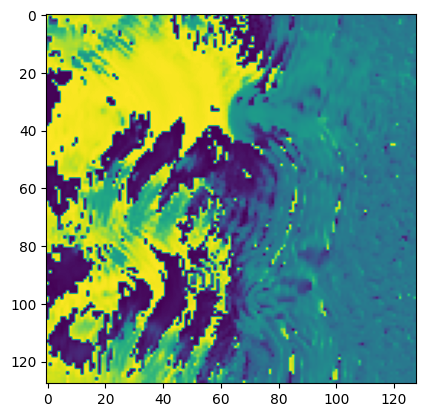

In [8]:
plt.imshow(p[100, :, :])

In [9]:
aa, pp = extract_amplitude_phase(sample_data, 4, 340)

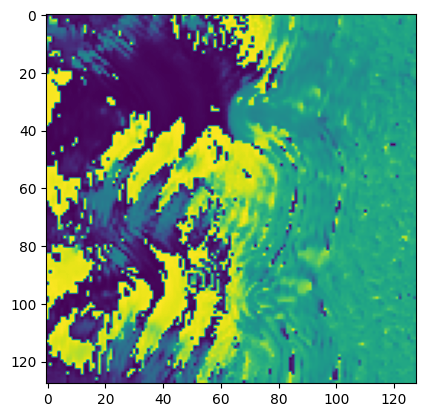

In [10]:
plt.imshow(pp[100, :, :])

In [41]:
aaa, ppp = extract_amplitude_phase_pytorch(sample_data, 4, 340)

In [11]:
%%timeit

a, p = make_full_fft(sample_data, 4, 340)

15.2 s ± 96.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit

aa, pp = extract_amplitude_phase(sample_data, 4, 340)

5.88 s ± 1.04 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%%timeit

aaa, ppp = extract_amplitude_phase_pytorch(sample_data, 4, 340)

6.44 s ± 439 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
